# Feature Importance and Selection


by Matt Marwedel  
  
## Import libraries

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from rfpimp import importances
from rfpimp import plot_importances
from rfpimp import permutation_importances
from rfpimp import oob_classifier_accuracy

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

## Table of Contents

- Spearman's Rank
- Random Forest
- Rfpimp Package
    - Permutation Importance
    - Drop Column Importance
- Comparing Strategies
- Automatic Feature Selection Algorithm

## Spearman's Rank  
  
Discovering what features are important for a model is an essential data science skill. The easiest way to do this by ranking the features by their Spearman's rank correlation coefficient. Spearman's rank uses the following formula to calculate the coefficients:  
  
$
\rho_{s} = 1 - \frac{6\sum_{i=1}^{n} d_{i}^{2}}{n(n^{2}-1)}
$  
  
In this formula $\rho_{s}=$ Spearman's rank coefficient, $d_i=$ difference between target rank and feature rank of each observation, and $n=$ number of observations.

Spearman's rank (and all other strategies covered in this project) will be examined using a public domain credit card fraud dataset from Kaggle. The dataset can be found at https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud. Here are the column definitions of the dataset from the Kaggle dataset description:  
- distance_from_home (numerical): the distance from home where the transaction happened. 
- distance_from_last_transaction (numerical): the distance from last transaction happened.
- ratio_to_median_purchase_price (numerical): ratio of purchased price transaction to median purchase price.
- repeat_retailer (binary): is the transaction happened from same retailer.
- used_chip (binary): is the transaction through chip (credit card).
- used_pin_number (binary): is the transaction happened by using PIN number.
- online_order (binary): is the transaction an online order.
- __Target variable__ fraud (binary): is the transaction fraudulent.

In [115]:
#Read in the data
credit = pd.read_csv('card_transdata.csv')
credit.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [116]:
#Calculate Spearman's rank coefficient between all features and the target and place in a dictionary
target = credit['fraud']
features = credit.drop('fraud', axis='columns')
spearmans_correlations = {}
for f_name, f in features.iteritems():
    f_ranked = f.rank()
    f_correlation, _ = spearmanr(f_ranked, target)
    spearmans_correlations[f_name] = f_correlation
#Sort the dictionary by corelation absolute values
ranked_spearman = dict(sorted(spearmans_correlations.items(), key=lambda x: abs(x[1]), reverse=True))

for k,v in ranked_spearman.items():
    print('Feature:',k,'Correlation:',v)    



Feature: ratio_to_median_purchase_price Correlation: 0.3428381155187382
Feature: online_order Correlation: 0.1919725223963063
Feature: used_pin_number Correlation: -0.100292537291623
Feature: distance_from_home Correlation: 0.09503246685299421
Feature: used_chip Correlation: -0.0609745976079359
Feature: distance_from_last_transaction Correlation: 0.034661056142350447
Feature: repeat_retailer Correlation: -0.0013574501055809588


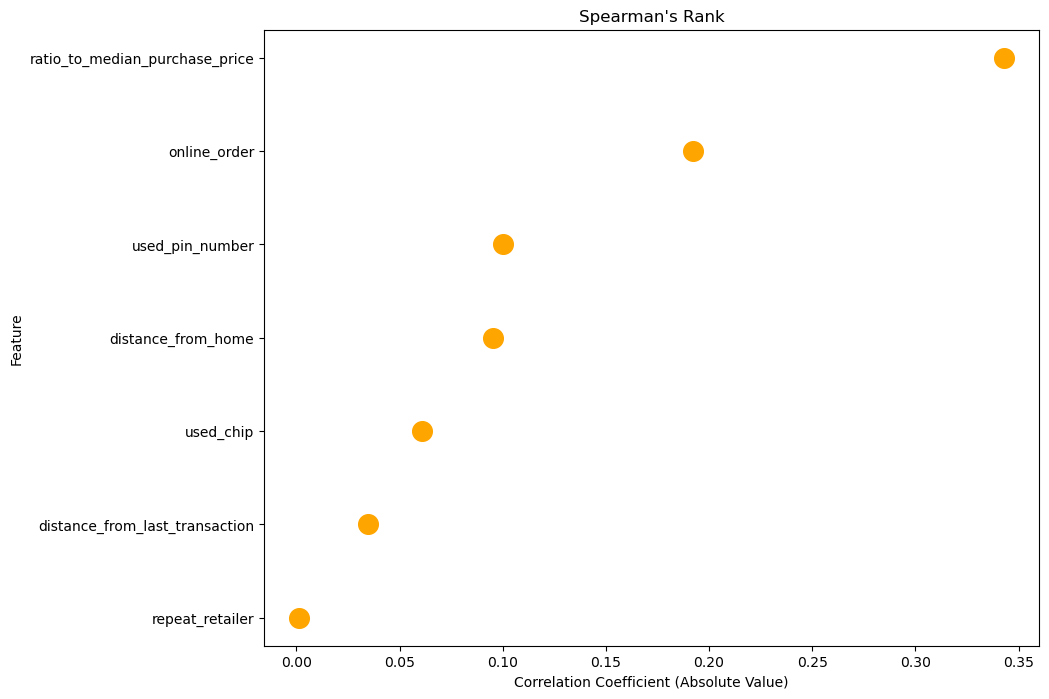

In [117]:
# Create a horizontal scatter plot of the feature rankings
corr_list= [abs(corr) for corr in ranked_spearman.values()]
corr_list.reverse()
feature_list = list(ranked_spearman.keys())
feature_list.reverse()
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(corr_list, range(len(ranked_spearman)), color='orange', s=200)
ax.set_yticks(range(len(ranked_spearman)))
ax.set_yticklabels(feature_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Correlation Coefficient (Absolute Value)')
ax.set_title('Spearman\'s Rank')
plt.show()

## Random Forest
Random Forest also calculates feature importance by using a feature's Gini score. A Gini score measures how important the feature is in the random forest model by calculation the reduction in impurtiy when splitting on that feature.  
  
Gini scores can be obtained for the credit card fraud dataset.

In [127]:
#Train a default Random Forest Classifier on the credit card fraud dataset
model = RandomForestClassifier(random_state=43)
model.fit(features, target)


RandomForestClassifier(random_state=43)

In [128]:
#Get the sorted Gini scores from the model and store in a sorted dataframe
gini = model.feature_importances_
gini_df = pd.DataFrame({'feature': features.columns, 'importance': gini})
gini_df = gini_df.sort_values('importance', ascending = False).reset_index(drop=True)

gini_df

,feature,importance
0,ratio_to_median_purchase_price,0.519435
1,online_order,0.179953
2,distance_from_home,0.125403
3,used_pin_number,0.065592
4,used_chip,0.056826
5,distance_from_last_transaction,0.045545
6,repeat_retailer,0.007246


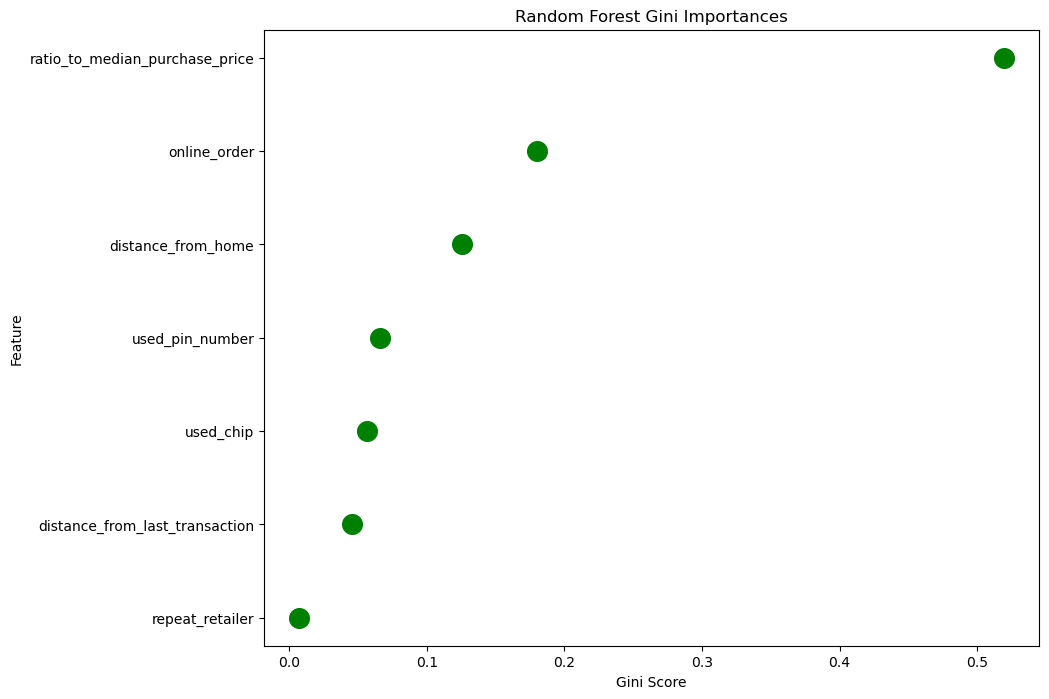

In [129]:
#Visualizing the Gini scores
gini_df = gini_df.sort_values('importance', ascending = True).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(gini_df.importance, range(len(gini_df)), color='green', s=200)
ax.set_yticks(range(len(gini_df)))
ax.set_yticklabels(gini_df.feature)
ax.set_ylabel('Feature')
ax.set_xlabel('Gini Score')
ax.set_title('Random Forest Gini Importances')
plt.show()

## Rfpimp Package  
  
Gini scores are known to be biased. The credit card fraud dataset Random Forest importances can also be calculated by permutation importance and drop column importance using the rfpimp package.

### Permutation Importance  

Permutation importance measures how much the random forest model's prediction performance changes when each feature is randomly permuted.

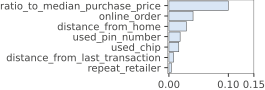

In [130]:
#Using the RandomForestClassifier model get permuation importances and plot them
permutations = importances(model, features, target)
plot_importances(permutations)

### Drop Column Importance  
  
Drop column importance measures how much the random forest model's prediciton performance changes when each feature is removed. For credit card fraud dataset use out-of-bag classification accuracy as the metric.

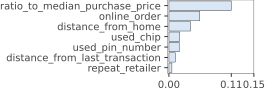

In [131]:
drop_col = permutation_importances(model, features, target, metric = oob_classifier_accuracy)
plot_importances(drop_col)

## Comparing Strategies  
  
The ranking of features by importance through Spearman, Random Forest (Gini), Permuation Importance, and Drop Column Importance on the credit card fraud dataset is summarized in the table below.

In [132]:
#Make a comparison table through a pandas dataframe
comparison = {'Spearman':['ratio_to_median_purchase_price', 'online_order', 'used_pin_number', 'distance_from_home', 'used_chip', 'distance_from_last_transaction', 'repeat_retailer'],
              'Random Forest (Gini)': ['ratio_to_median_purchase_price', 'online_order',  'distance_from_home', 'used_pin_number', 'used_chip', 'distance_from_last_transaction', 'repeat_retailer'],
              'Permuation Importance': ['ratio_to_median_purchase_price', 'online_order', 'distance_from_home', 'used_pin_number', 'used_chip', 'distance_from_last_transaction', 'repeat_retailer'],
              'Drop Column Importance': ['ratio_to_median_purchase_price', 'online_order', 'distance_from_home', 'used_chip', 'used_pin_number',  'distance_from_last_transaction', 'repeat_retailer']}
comparison_df = pd.DataFrame(comparison)
comparison_df.index = comparison_df.index +1
#Style the table
df_styled = comparison_df.style.set_table_styles([{'selector': 'th',
                        'props': [('text-align', 'center'),
                                  ('background-color', 'white'),
                                  ('color', 'black'),
                                  ('font-weight', 'bold'),
                                  ('border', '1px solid black')]},
                        {'selector': 'td',
                        'props': [('border', '1px solid black')]}])
display(df_styled)

,Spearman,Random Forest (Gini),Permuation Importance,Drop Column Importance
1,ratio_to_median_purchase_price,ratio_to_median_purchase_price,ratio_to_median_purchase_price,ratio_to_median_purchase_price
2,online_order,online_order,online_order,online_order
3,used_pin_number,distance_from_home,distance_from_home,distance_from_home
4,distance_from_home,used_pin_number,used_pin_number,used_chip
5,used_chip,used_chip,used_chip,used_pin_number
6,distance_from_last_transaction,distance_from_last_transaction,distance_from_last_transaction,distance_from_last_transaction
7,repeat_retailer,repeat_retailer,repeat_retailer,repeat_retailer


## Automatic Feature Selection Algorithm  
  
An algorithm to drop features from a model until the optimal model (based on some performance metric) is created is an excellent example of the power of feature selection. An algorithm using Spearman's rank for feature importances, a Random Forest classification model, and F1 score as a performance metric is created below for the credit card fraud dataset.

In [133]:
def feature_selection(features, target):
    #Make a dictionary of ranked Spearman correlation scores using the code from earlier
    spearmans_correlations = {}
    for f_name, f in features.iteritems():
        f_ranked = f.rank()
        f_correlation, _ = spearmanr(f_ranked, target)
        spearmans_correlations[f_name] = f_correlation
    #Sort the dictionary by corelation absolute values and make a list of the ranked feature names
    ranked_spearman = dict(sorted(spearmans_correlations.items(), key=lambda x: abs(x[1]), reverse=True))
    #Make a list of ranked features to remove from one by one until f1 score is optimal
    optimal_features = list(ranked_spearman.keys())
    #Get the initial f1 score from a model with all the features and set it as the best f1
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    initial_model = RandomForestClassifier()
    initial_model.fit(X_train, y_train)
    initial_pred = initial_model.predict(X_test)
    best_f1 = f1_score(y_test, initial_pred)
    #Iterate through the features, comparing the best f1 with the f1 from a new model without the least important optimal feature
    #Stop iterating and return the optimal features once the new_f1 is less than the best_f1
    for feature in range(len(ranked_spearman)):
        X_train, X_test, y_train, y_test = train_test_split(features[optimal_features[:-1]], target, test_size=0.2, random_state=42)
        new_model = RandomForestClassifier()
        new_model.fit(X_train, y_train)
        new_pred = new_model.predict(X_test)
        new_f1 = f1_score(y_test, new_pred)
        if new_f1 >= best_f1:
            best_f1 == new_f1
            optimal_features == optimal_features.pop()
        else:
            return optimal_features

In [134]:
optimal_credit = feature_selection(features, target)
print(optimal_credit)

['ratio_to_median_purchase_price', 'online_order', 'used_pin_number', 'distance_from_home', 'used_chip', 'distance_from_last_transaction']


In [135]:
print('Initial features in credit card fraud dataset:',list(ranked_spearman.keys()))
print('Optimal features in credit card fraud dataset:',optimal_credit)

Initial features in credit card fraud dataset: ['ratio_to_median_purchase_price', 'online_order', 'used_pin_number', 'distance_from_home', 'used_chip', 'distance_from_last_transaction', 'repeat_retailer']
Optimal features in credit card fraud dataset: ['ratio_to_median_purchase_price', 'online_order', 'used_pin_number', 'distance_from_home', 'used_chip', 'distance_from_last_transaction']
